## Homework 2
### Olivia Cooper
### Computational Astrophysics, Spring 2022

In [1]:
# the basics

import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import astropy
import sod_exact
plt.style.use('../cooper-paper.mplstyle')

# function to find closest value in array to specific number

def closest(lst, val):
    lst = np.asarray(lst) 
    idx = (np.abs(lst - val)).argmin() 
    return idx,lst[idx]

### Problem 1: Not so fast!

Use a perturbation analysis to show that the leapfrog scheme (time-centered
difference):

$\rho_j^{n+1} - \rho_j^{n-1} = -v_0 \frac{\Delta t}{\Delta x} (\rho_{j+1}^{n} - \rho_{j-1}^{n})$

is conditionally stable, i.e. it is stable as long as $\Delta t \leq \frac{\Delta x}{v_0}$. Assume that $v_0$ is a constant
velocity.

First, introduce the perturbation:

$\rho_j^n(k) = \xi_j^n e^{ikj\Delta x}$

Now, apply this to our leapfrog scheme and simplify.

$\xi_j^{n+1} e^{ikj\Delta x} - \xi_j^{n-1} e^{ikj\Delta x} =  \frac{-v_0\Delta t}{\Delta x} (\xi_{j+1}^{n} e^{ik(j+1)\Delta x} - \xi_{j-1}^{n} e^{ik(j-1)\Delta x})$

$\xi_j^{n+1}  - \xi_j^{n-1}  =  \frac{-v_0\Delta t}{\Delta x} (\xi_{j+1}^{n} e^{ik\Delta x} - \xi_{j-1}^{n} e^{-ik\Delta x})$

$\xi  - \xi^{-1}  =  \frac{-v_0\Delta t}{\Delta x} (e^{ik\Delta x} -  e^{-ik\Delta x})$

We know that $\xi$ is small, so the $1/\xi$ goes to zero. Now we can substitute in a sine function for the exponential terms.

$\xi  =  \frac{-v_0\Delta t}{\Delta x} (e^{ik\Delta x} -  e^{-ik\Delta x})$

$\xi  =  \frac{-v_0\Delta t}{\Delta x} (i sin(k\Delta x))$

We showed in class that in the case $||\xi||>1$, the perturbation grows with time and is unconditionally unstable. So, solve for $||\xi||\leq1$ to find when the scheme is conditionally stable.

$||\xi||  =  \left[\frac{v_0^2\Delta t^2}{\Delta x^2} (sin^2(k\Delta x))\right]^{1/2}$

The $sin^2(k\Delta x)$ term will oscillate from 0 to 1, with a maximum value of 1. Taking this maximum case, we can write our condition and simplify:

$\left[\frac{v_0^2\Delta t^2}{\Delta x^2}\right]^{1/2} \leq 1$

$\Delta t \leq \frac{\Delta x}{v_0}$

### Problem 2: Sod Shock Tube

Using the finite volume discretization given in class and a programming language
of your choice, write your own 1D hydrodynamic solver.

a) The quintessential shock benchmark problem is the “Sod Shock Tube” (first formulated
by Sod in 1978). The problem involves setting up two discontinuous states at $t = 0$: a hot
dense gas on the left and a cool, low-density gas on the right. The result is a shock wave
that travels left to right into the cold gas, and a rarefaction wave that travels into the dense
gas on the left.

Let the domain be [0,2], and set ρ1 = 1.0, p1 = 1.0 for x ≤0.75 and ρ2 = 0.125,
p2 = 0.1 for x > 0.75. Assume γ = 1.4 and use this to determine the specific energy. Set
v = 0 everywhere initially. Use symmetry boundary conditions and N = 200 grid cells. Set
the time step according to a CFL number of 0.5.

Compute the solution at t = 0.245 and make plots of the density, velocity, pressure and
specific energy as a function of position. Compare the shock properties (speed, density
jump, pressure jump, velocity) with that predicted for these conditions (e.g. see Stone &
Norman 1992).

In [2]:
# set initial conditions
gamma = 1.4
rhoL = 1.; rhoR = 0.125
prL = 1.; prR = 0.1
velL = 0.; velR = 0.
xL = 0.; xi = 0.75; xR = 2.
CFL = 0.5

In [3]:
# define variable arrays where N=200 points
N = 200
data = np.arange(1,N+1,dtype=int) # define indices of data to exclude the buffer
ip1 = np.arange(2,N+2,dtype=int) # define indices of data to call i+1
im1 = np.arange(0,N,dtype=int) # define indices of data to call i-1
x_old = np.linspace(start=xL, stop=xR, num=N); x_new = np.zeros(N) # position, includes init cond for x
rho_old = np.zeros(N); rho_new = np.zeros(N) # density
vel_old = np.zeros(N); vel_new = np.zeros(N) # velocity
pr_old = np.zeros(N); pr_new = np.zeros(N) # pressure
en_old = np.zeros(N); en_new = np.zeros(N) # energy
qvisc_old = np.zeros(N); qvisc_new = np.zeros(N) # artificial viscosity

x_old = np.pad(x_old, (1,1), 'constant'); x_new = np.pad(x_new, (1,1), 'constant')
rho_old = np.pad(rho_old, (1,1), 'constant'); rho_new = np.pad(rho_new, (1,1), 'constant') # density
vel_old = np.pad(vel_old, (1,1), 'constant'); vel_new = np.pad(vel_new, (1,1), 'constant') # velocity
pr_old = np.pad(pr_old, (1,1), 'constant'); pr_new = np.pad(pr_new, (1,1), 'constant') # pressure
en_old = np.pad(en_old, (1,1), 'constant'); en_new = np.pad(en_new, (1,1), 'constant') # energy
qvisc_old = np.pad(qvisc_old, (1,1), 'constant'); qvisc_new = np.pad(qvisc_new, (1,1), 'constant') # artificial viscosity

In [4]:
# define ND arrays to dump results into
Nn = len(x_old)
x = np.empty((10001,Nn))
u = np.empty((10001,Nn))
P = np.empty((10001,Nn))
rho = np.empty((10001,Nn))
q = np.empty((10001,Nn))
e = np.empty((10001,Nn))

In [5]:
# apply initial conditions to the other arrays
left = np.where(x_old <= xi)
right = np.where(x_old > xi)

rho_old[left] = rhoL; rho_old[right] = rhoR
pr_old[left] = prL; pr_old[right] = prR
en_old = pr_old/(rho_old*(gamma-1))

In [6]:
# dump t=0 conditions into results arrays
x[0] = x_old
u[0] = vel_old
P[0] = pr_old
rho[0] = rho_old
q[0] = qvisc_old
e[0] = en_old

In [7]:
# set cell mass
dm_i = rho_old[data]*(np.max(x_old[data]) - np.min(x_old[data]))/N 
dm_ip1 = rho_old[ip1]*(np.max(x_old[ip1]) - np.min(x_old[ip1]))/N

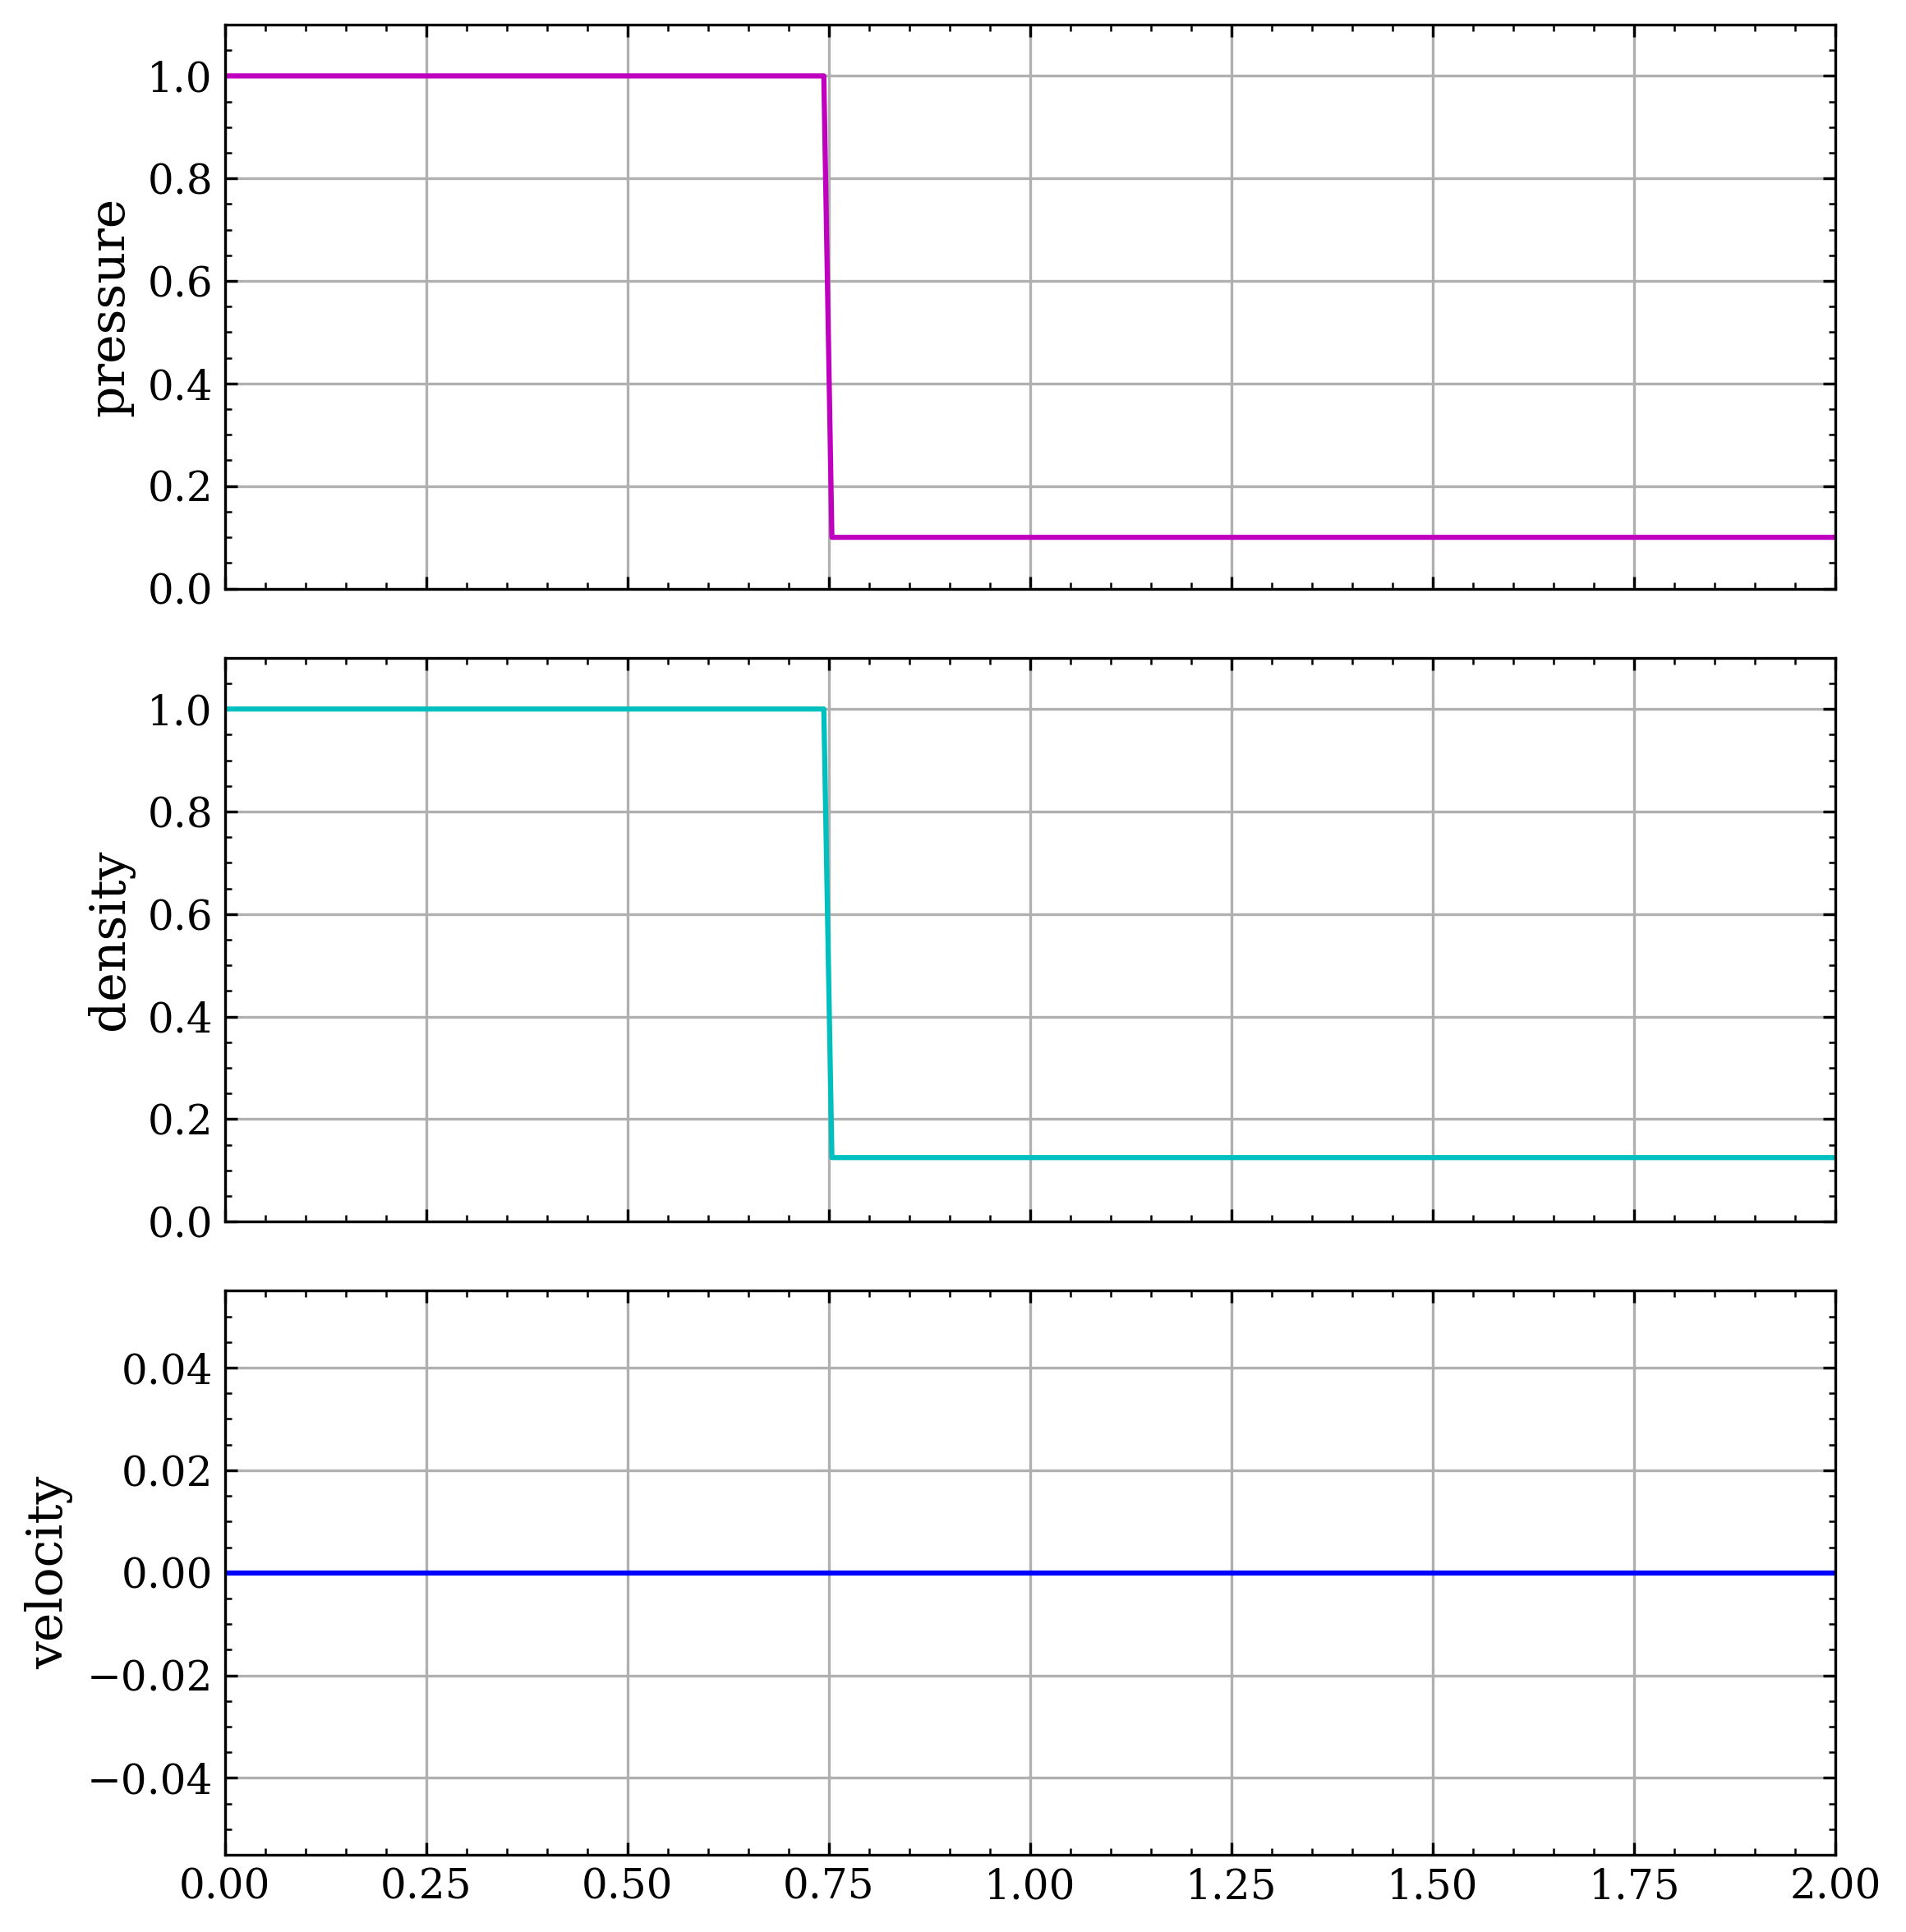

In [8]:
# plot the initial conditions we set as a sanity check
f, ax = plt.subplots(3, sharex=True, figsize=(8,8))

ax[0].plot(x_old[data], pr_old[data], 'm')
ax[0].set_ylabel('pressure')
ax[0].set_ylim(0, 1.1)
ax[0].set_xlim(xL, xR)

ax[1].plot(x_old[data], rho_old[data], 'c')
ax[1].set_ylabel('density')
ax[1].set_ylim(0, 1.1)
ax[1].set_xlim(xL, xR)

ax[2].plot(x_old[data], vel_old[data], 'b')
ax[2].set_ylabel('velocity')
ax[2].set_xlim(xL, xR)

plt.show()

In [9]:
# calculate timestep using CFL condition

def soundspeed(gamma, pressure, density):
    """
    Calculate the sound speed

    Parameters
    ----------
    gamma : TYPE
        DESCRIPTION.
    pressure : TYPE
        DESCRIPTION.
    density : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """

    return np.sqrt(gamma * pressure / density)


def timestep(pos=x_old[data], cfl=CFL, gamma=gamma, P=pr_old[data], rho=rho_old[data], vel=vel_old[data]):
    
    dx = (np.max(pos[data])-np.min(pos[data]))/N
    cs = np.ma.masked_invalid(np.array([soundspeed(gamma, pressure=P[i], density=rho[i]) for i in range(N)]))
    dt = (CFL * dx) / np.max((cs + vel))
    return dt

In [13]:
#dt = 0.001
cs = np.ma.masked_invalid(np.array([soundspeed(gamma, pressure=pr_old[i], density=rho_old[i]) for i in range(Nn)]))
dt = timestep(pos=x_old, cfl=CFL, gamma=gamma, P=pr_old, rho=rho_old)

In [14]:
def velocity(vel=vel_old,vel2=vel_new,dt=dt,pr=pr_old,q=qvisc_old,dm=dm_i):
    
    rhs = dt*(pr[ip1] - pr[data] + q[ip1] - q[data])/dm
    new = vel[data] - rhs
    old = vel2
    return new, old

def position(vel=vel_new,dt=dt,x=x_old,x2=x_new):
    
    rhs = dt*vel[data]
    new = x[data] + rhs
    old = x2
    return new, old

def density(dm=dm_ip1,x=x_new,rho2=rho_new):
    
    new = (dm)/(x[ip1] - x[data])
    old = rho2
    return new, old


def artvisc(rho1=rho_old,rho2=rho_new,vel=vel_old,x=x_old,cs=cs):
    
    rho_avg = 0.5*((1/rho2[ip1])+(1/rho1[ip1]))
    q0 = 4
    q1 = 0.5

    q = np.zeros(N)
    for j in range(N+1):

        cond = (vel[j+1]-vel[j])/(x[j+1]-x[j])
        if cond < 0:
            q[j+1] = (q0*(vel[j+1]-vel[j])**2 - q1*(vel[j+1]-vel[j]))*(cs[j+1]/rho_avg[j]) 
        else:
            pass

    return q

def energy(pr=pr_old,q=qvisc_old,rho2=rho_new,rho1=rho_old,en=en_old,en2=en_new):
    
    rhs = (pr[ip1]+q[ip1])*(1/rho2[ip1] - 1/rho1[ip1])
    #rhs = (pr[ip1])*(1/rho2[ip1] - 1/rho1[ip1])
    new = en[ip1] - rhs
    old = en2
    return new, old

def pressure(en=en_new,rho=rho_new,gamma=gamma,p2=pr_new):
    
    new = en[ip1]*rho[ip1]*(gamma-1)
    old = p2
    return new, old

In [ ]:
dx = (np.max(pos[data])-np.min(pos[data]))/N
cs = np.array([soundspeed(gamma, pressure=P[i], density=rho[i]) for i in range(N)])
dt = (CFL * dx) / np.max((cs + vel))

In [15]:
t = 0.0
#dt = 0.0001
ct = 1
tmax = 1.
time = []

while t < tmax:
    dt = timestep(pos=x_old, cfl=CFL, gamma=gamma, P=pr_old, rho=rho_old)
    
    print("counter = ",ct)
    time.append(t)
    print("at time = ",t)
    
    if t + dt > tmax:
        dt = tmax - t

    # solve for new velocity
    vel_new[data], vel_old = velocity()
    u[ct] = vel_new

    # compute new grid positions
    x_new[data], x_old = position()
    x[ct] = x_new

    # compute new density
    rho_new[ip1], rho_old = density()
    rho[ct] = rho_new

    # compute new sound speed
    cs = np.array([soundspeed(gamma, pressure=pr_old[i], density=rho_new[i]) for i in range(N)])

    # compute new artificial viscosity
    qvisc_old[ip1] = artvisc()
    q[ct] = qvisc_new

    # compute new energy
    en_new[ip1], en_old = energy()
    e[ct] = en_new

    # compute new pressure
    pr_new[ip1], pr_old = pressure()
    P[ct] = pr_new

    t += dt
    ct += 1

counter =  1
at time =  0.0
counter =  2
at time =  0.004225771273642583
counter =  3
at time =  0.008434539561362253
counter =  4
at time =  0.012643307849081922
counter =  5
at time =  0.01685207613680159
counter =  6
at time =  0.02106084442452126
counter =  7
at time =  0.02526961271224093
counter =  8
at time =  0.0294783809999606
counter =  9
at time =  0.03368714928768027
counter =  10
at time =  0.03789591757539994
counter =  11
at time =  0.042104685863119606
counter =  12
at time =  0.046313454150839276
counter =  13
at time =  0.050522222438558945
counter =  14
at time =  0.054730990726278614
counter =  15
at time =  0.05893975901399828
counter =  16
at time =  0.06314852730171795
counter =  17
at time =  0.06735729558943762
counter =  18
at time =  0.07156606387715729
counter =  19
at time =  0.07577483216487696
counter =  20
at time =  0.07998360045259663
counter =  21
at time =  0.0841923687403163
counter =  22
at time =  0.08840113702803597
counter =  23
at time =  0.092

<ipython-input-9-175fd6bcbd53>:23: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(gamma * pressure / density)
<ipython-input-14-3a9a6c30f374>:31: RuntimeWarning: invalid value encountered in double_scalars
  cond = (vel[j+1]-vel[j])/(x[j+1]-x[j])
<ipython-input-9-175fd6bcbd53>:23: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(gamma * pressure / density)


counter =  170
at time =  0.7112988436105451
counter =  171
at time =  0.7155076118982647
counter =  172
at time =  0.7197163801859844
counter =  173
at time =  0.723925148473704
counter =  174
at time =  0.7281339167614237
counter =  175
at time =  0.7323426850491433
counter =  176
at time =  0.736551453336863
counter =  177
at time =  0.7407602216245827
counter =  178
at time =  0.7449689899123023
counter =  179
at time =  0.749177758200022
counter =  180
at time =  0.7533865264877416
counter =  181
at time =  0.7575952947754613
counter =  182
at time =  0.7618040630631809
counter =  183
at time =  0.7660128313509006
counter =  184
at time =  0.7702215996386202
counter =  185
at time =  0.7744303679263399
counter =  186
at time =  0.7786391362140596
counter =  187
at time =  0.7828479045017792
counter =  188
at time =  0.7870566727894989
counter =  189
at time =  0.7912654410772185
counter =  190
at time =  0.7954742093649382
counter =  191
at time =  0.7996829776526578
counter =  19

In [ ]:
cs

In [ ]:
# exact analytical solution
positions, regions, result = sod_exact.solve(prL, rhoL, velL, prR, rhoR, velR, xL, xR, xi, t=0.245, gamma=gamma, N=N)
f, ax = plt.subplots(3, sharex=True, figsize=(8,8))

ax[0].plot(result['x'], result['P'], 'm')
ax[0].set_ylabel('pressure')
ax[0].set_ylim(0, 1.1)

ax[1].plot(result['x'], result['rho'], 'c')
ax[1].set_ylabel('density')
ax[1].set_ylim(0, 1.1)

ax[2].plot(result['x'], result['u'], 'b')
ax[2].set_ylabel('velocity')

plt.show()

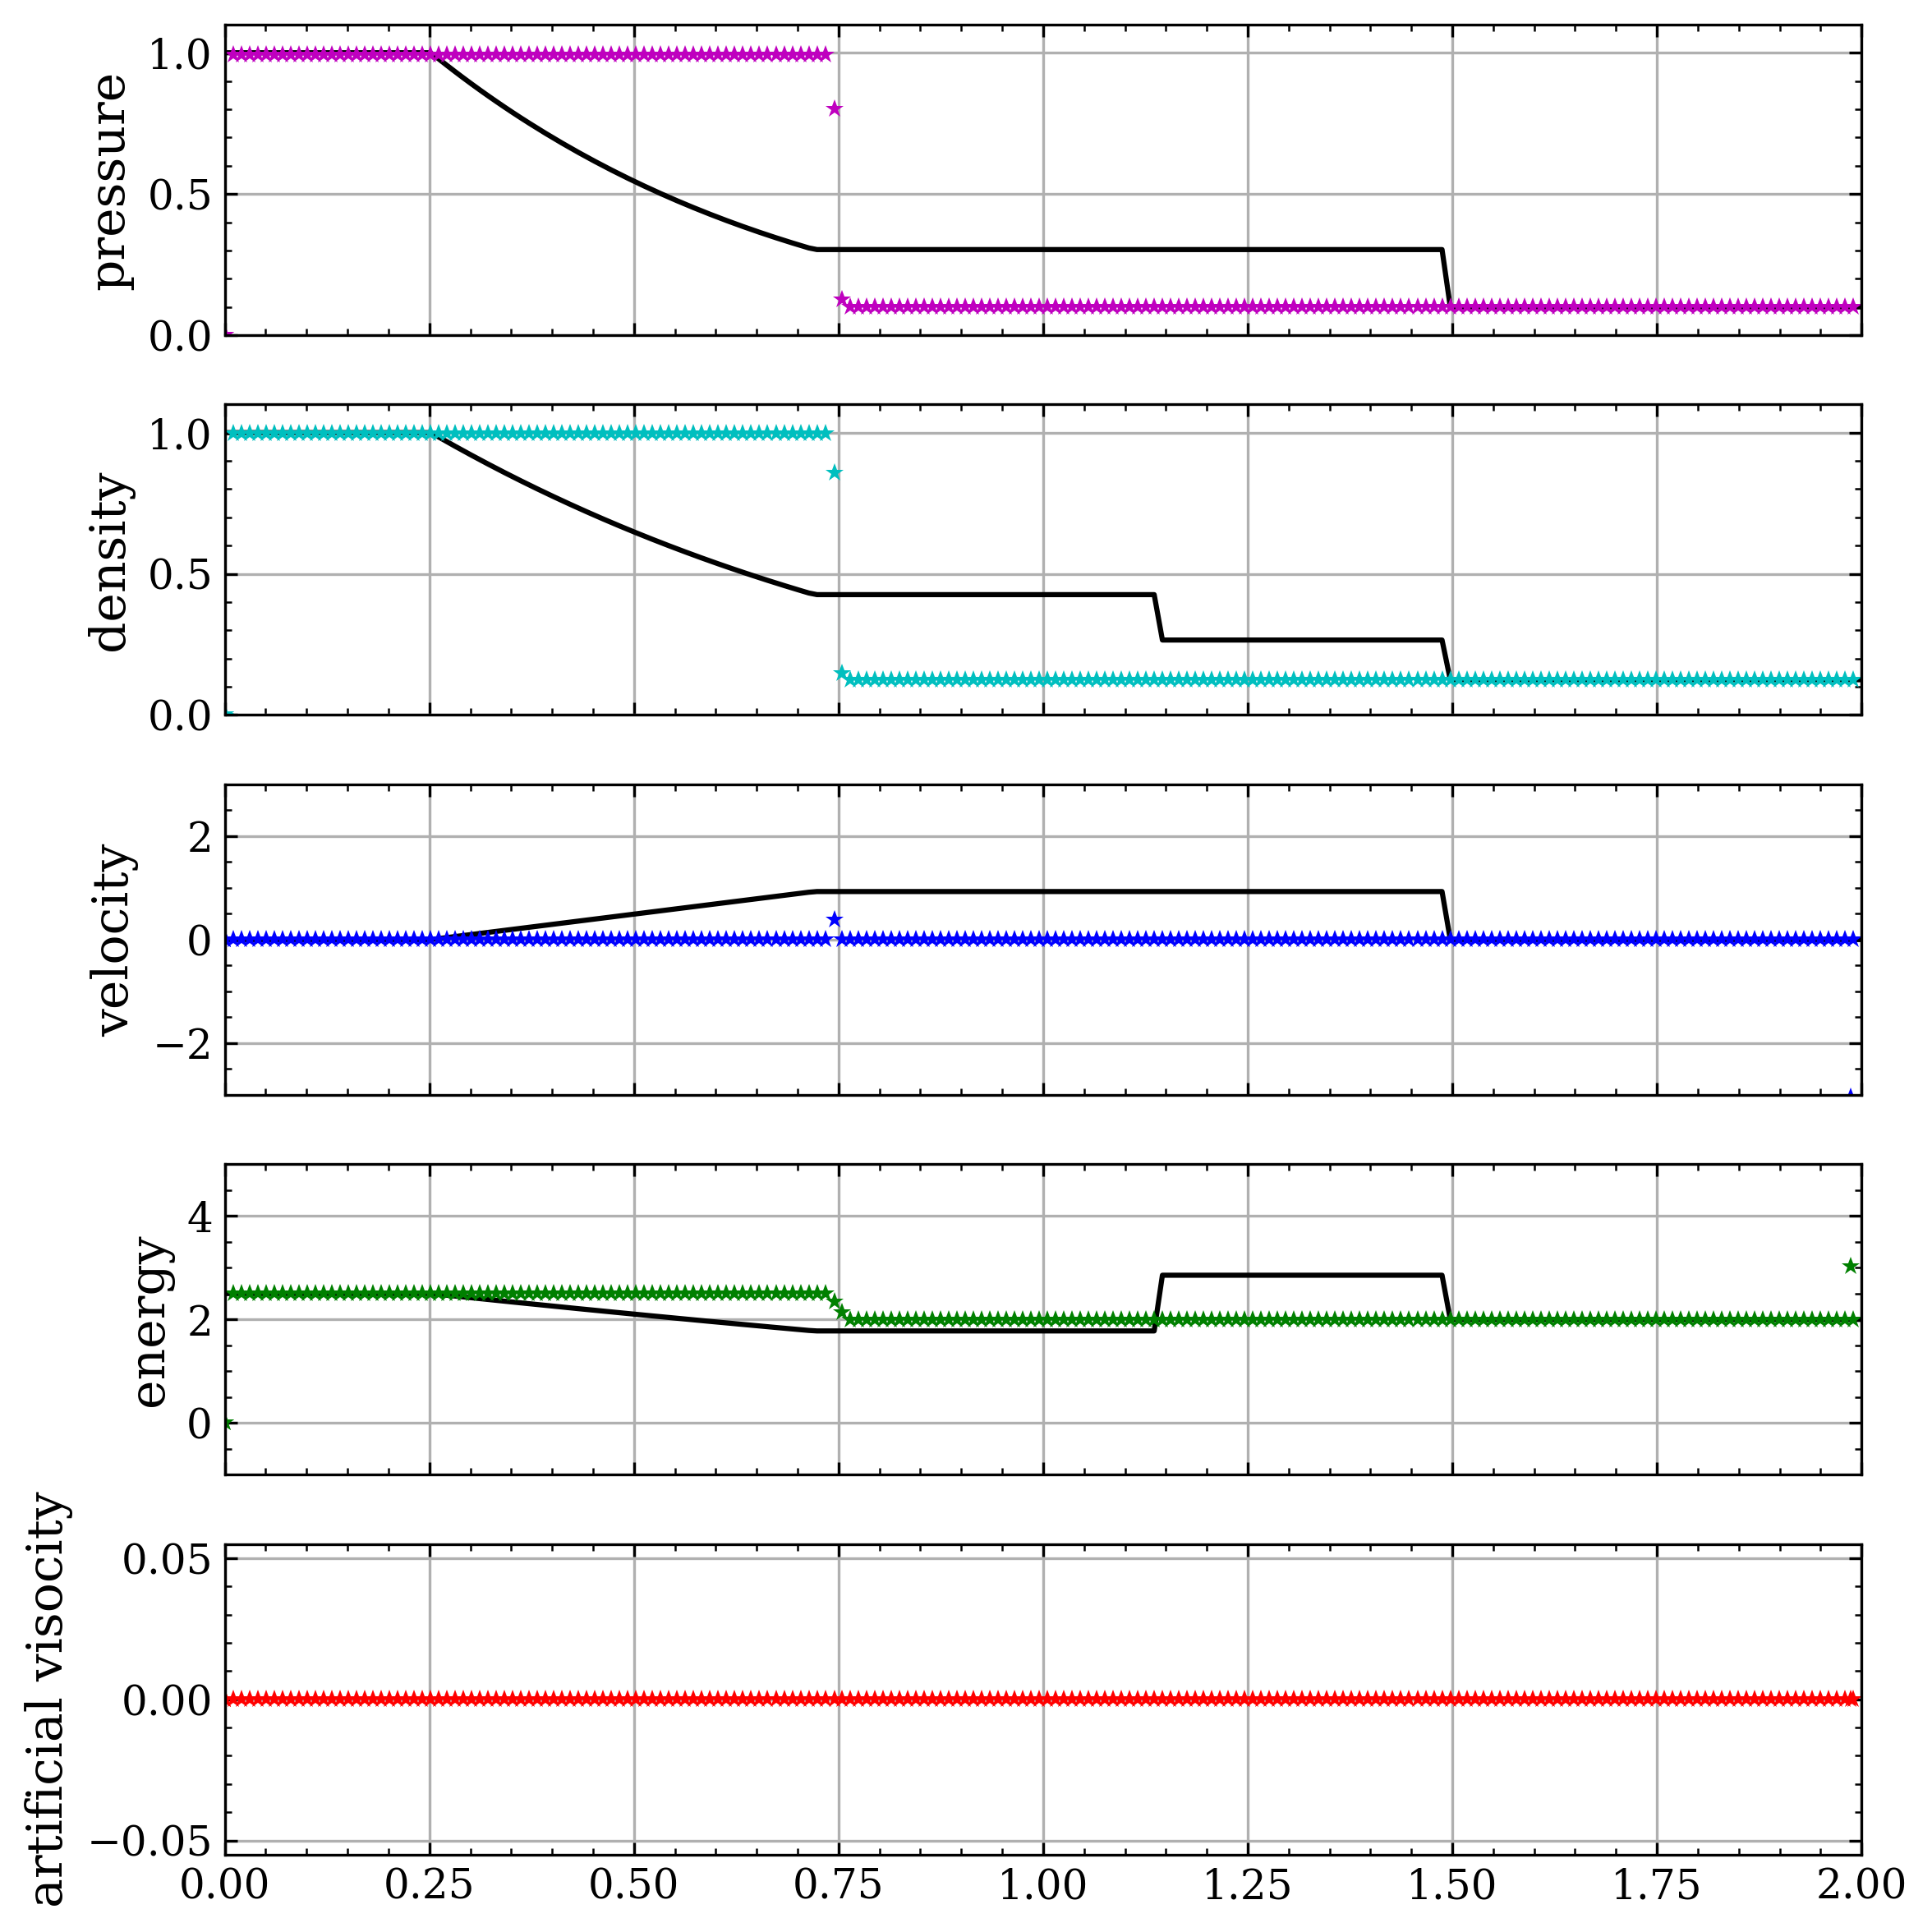

In [17]:
idx = 100
positions, regions, result = sod_exact.solve(prL, rhoL, velL, prR, rhoR, velR, xL, xR, xi, t=time[idx], gamma=gamma, N=N)
f, ax = plt.subplots(5, sharex=True, figsize=(8,8))

ax[0].plot(result['x'], result['P'], 'k')
ax[0].plot(x[idx], P[idx], 'm*')
ax[0].set_ylabel('pressure')
ax[0].set_ylim(0, 1.1)

ax[1].plot(result['x'], result['rho'], 'k')
ax[1].plot(x[idx], rho[idx], 'c*')
ax[1].set_ylabel('density')
ax[1].set_ylim(0, 1.1)

ax[2].plot(result['x'], result['u'], 'k')
ax[2].plot(x[idx], u[idx], 'b*')
ax[2].set_ylabel('velocity')
ax[2].set_ylim(-3, 3)

ax[3].plot(result['x'], result['energy'], 'k')
ax[3].plot(x[idx], e[idx], 'g*')
ax[3].set_ylabel('energy')
ax[3].set_ylim(-1, 5)

ax[4].plot(x[idx], q[idx], 'r*')
ax[4].set_ylabel('artificial visocity')
#ax[4].set_ylim(0, 1.1)

plt.xlim(0,2)
plt.show()